# Project 2: Mini deep-learning framework

In [1]:
#!/usr/bin/env python3
""" File to solve the second miniproject which is the design of a framework """

import math
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import empty

__author__ = 'Eugène Lemaitre, Natalie Bolón Brun, Louis Munier'
__version__ = '0.1'

torch.set_grad_enabled(False)

# Data generation and plotting

In [2]:
def generate_disc_set(nb):
    X = empty(nb,2).uniform_(0,1)
    Y = empty(X.size())
    
    Y[:,0] = ((X - 0.5).norm(dim=1)  >  math.sqrt(1/(2*math.pi))).type(torch.LongTensor)
    Y[:,1] = ((X - 0.5).norm(dim=1)  <=  math.sqrt(1/(2*math.pi))).type(torch.LongTensor)
    
    return X, Y

def plot_disc(data_in, data_target, title):
    plt.scatter(data_in[(data_target[:,1]==1),0] ,data_in[(data_target[:,1]==1),1], color = "c", s=20)
    plt.scatter(data_in[(data_target[:,1]==0),0] ,data_in[(data_target[:,1]==0),1], color = "g", s=20)
    plt.title(title)
    plt.legend(["1", "0"] )
    plt.show()

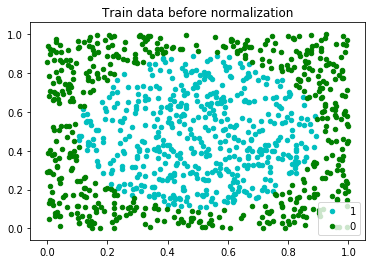

Point outside:  509
Point inside:   491


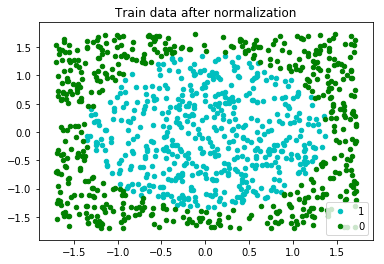

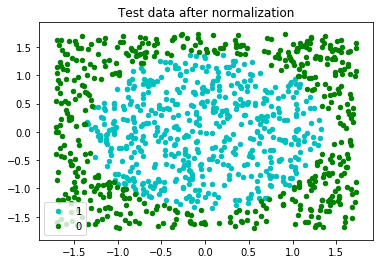

In [3]:
Sample_number = 1000
train_input, train_target = generate_disc_set(Sample_number)
test_input, test_target = generate_disc_set(Sample_number)

plot_disc(train_input, train_target, "Train data before normalization")
    
print("Point outside: ", train_input[(train_target[:,1]==0),0].size(0))
print("Point inside:  ", train_input[(train_target[:,1]==1),0].size(0))

mu, std = train_input.mean(0), train_input.std(0)
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)

plot_disc(train_input, train_target, "Train data after normalization")
plot_disc(test_input, test_target, "Test data after normalization")

# Module

In [4]:
class Module():
    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError

    def param(self):
        return []

## Linear

In [5]:
class Linear(Module): 
    def __init__(self, dim_in, dim_out):
        x = empty((0,0))
        s = empty((0,0))
        
        self.bias = empty(1, dim_out)
        self.weight = empty(dim_out, dim_in)
            
        gradwrtbias = empty((0,0))
        gradwrtweight = empty((0,0))
    
    def forward(self, *input):
        self.x = input[0]
        self.s = self.x.mm(self.weight.t()) + self.bias
        return self.s

    def backward(self, *gradwrtoutput):
        self.gradwrtbias = torch.ones(1, self.x.size(dim=0)).mm(gradwrtoutput[0])
        self.gradwrtweight = gradwrtoutput[0].t().mm(self.x)
        return gradwrtoutput[0].mm(self.weight)
        
    def param(self):
        return [self.bias, self.weight]
        
    def normalize_parameters(self, mean, std):
        self.bias = self.bias.normal_(mean=mean, std=std)
        self.weight = self.weight.normal_(mean=mean, std=std)
        
    def define_parameters(self, weight, bias):
        self.bias = bias.view((1, bias.numel()))
        self.weight = weight
        
    def update_parameters(self, eta):
        self.bias -= eta * self.gradwrtbias
        self.weight -= eta * self.gradwrtweight

## Loss

In [6]:
class Loss(Module):
    def __init__(self):
        output = empty((0,0))
        target_output = empty((0,0))
    
    def forward(self, *input):
        self.output = input[0]
        self.target_output = input[1]

    def backward(self, *gradwrtoutput):
        raise NotImplementedError

    def param(self):
        return []

### MSE

In [7]:
class LossMSE(Loss):
    def __init__(self):
        Loss.__init__(self)
        
    def forward(self, output, target_output):
        Loss.forward(self, output, target_output)
        loss = (self.output - self.target_output).pow(2).mean()  # (dim=0).sum()
        return loss

    def backward(self):
        return 2*(self.output - self.target_output)/self.output.numel()  # size(dim=0)

    def param(self):
        return []

### Cross Entropy

In [8]:
class CrossEntropy(Loss):
    def __init__(self):
        Loss.__init__(self)
    
    def forward(self, output, target_output):
        Loss.forward(self, output, target_output)
        loss =  -1./self.output.size(dim=0) * (self.output[ (torch.arange(0, self.output.size(dim=0) )).type(torch.long), self.target_output].sum() - self.output.exp().sum(dim=1).log().sum() ) 
        return loss
        
    def backward(self):
        grad = empty(self.output.size())
        for i in range(0, self.output.size(dim=0)):
            grad[i,:] = self.output[i,:].exp().div_(self.output[i,:].exp().sum())
       
        grad[(torch.arange(0, self.output.size(dim=0))).type(torch.long), self.target_output] -= 1
        grad.div_(self.output.size(dim=0))
        return grad
            

    def param(self):
        return []

## Activations

In [9]:
class Activation(Module):
    def __init__(self):
        self.s = empty((0,0))

    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError

    def param(self):
        return []

### Tanh

In [10]:
class Tanh(Activation):
    def __init__(self):
        Activation.__init__(self)
        
    def forward(self, x):
        self.s = x
        return x.tanh()

    def backward(self, *gradwrtoutput):
        return (1 - (self.s.tanh()).pow(2)) * (gradwrtoutput[0])
        
    def param(self):
        return []

### ReLU

In [11]:
class Relu(Activation):
    def __init__(self):
        Activation.__init__(self)
    
    def forward(self, x):
        self.s = x
        
        y = empty(self.s.size()).zero_()
        y[x>0] = x[x>0]
        
        return y

    def backward(self, *gradwrtoutput):
        y = empty(gradwrtoutput[0].size()).zero_()
        y[self.s > 0] = gradwrtoutput[0][self.s > 0]
        
        return y

    def param(self):
        return []

### Sigmoid

In [12]:
class Sigmoid(Activation):
    def __init__(self, p_lambda):
        Activation.__init__(self)
        self.p_lambda = p_lambda
    
    def forward(self, x):
        self.s = x
        return 1/(1 + (-self.p_lambda*x).exp())

    def backward(self, *gradwrtoutput):
        return (self.p_lambda * (-self.s * self.p_lambda).exp()) / ((-self.s * self.p_lambda).exp() + 1).pow(2)

    def param(self):
        return [self.p_lambda]

## Optimizers

In [13]:
class Optimizers():
    def __init__(self):
        self.s = empty((0,0))

    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError

    def param(self):
        return []

### SGD

In [14]:
class Sgd(Optimizers):
    def __init__(self):
        self.s = empty((0,0))

    def forward(self, *input):
        raise NotImplementedError

    def backward(self, *gradwrtoutput):
        raise NotImplementedError

    def param(self):
        return []

# Sequential

In [15]:
class Sequential(Module):
    def __init__(self, sequence, loss):
        self.sequence = sequence
        self.loss = loss
    
    def forward(self, x):
        for step in self.sequence:
            x = step.forward(x)
        return x
    
    def compute_loss(self, output, target_output):
        if type(self.loss) == CrossEntropy:
            return self.loss.forward(output, target_output.argmax(dim=1))
        else:
            return self.loss.forward(output, target_output)

    def backward(self):
        grad = self.loss.backward()
        for step in reversed(self.sequence):
            grad = step.backward(grad)
    
    def normalize_parameters(self, mean, std):
        for step in reversed(self.sequence):
            if step.param() != []:
                step.normalize_parameters(mean, std)
                
    def update_parameters(self, eta):
        for step in reversed(self.sequence):
            if step.param() != []:
                step.update_parameters(eta)
    
    def param(self):
        return []

### Compute number error

In [16]:
def compute_number_error(output_one_hot, target_one_hot):
    output = output_one_hot.argmax(dim=1)
    target = target_one_hot.argmax(dim=1)
    nb_of_error = (output != target).sum()
    return nb_of_error

# Test 

In [17]:
# Model definition:
hidden_nb = 25

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model = Sequential([linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4 ], loss) 
    
std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000

model.normalize_parameters(mean=0, std=std)

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model.compute_loss(output, train_target.narrow(0, b, batch_size))
        model.backward()
        model.update_parameters(eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
        eta = eta*0.95

0 :  0.6921746730804443
50 :  0.11061721295118332
100 :  0.03004913218319416
150 :  0.025184936821460724
200 :  0.02770141512155533
250 :  0.0303808581084013
300 :  0.03664489835500717
350 :  0.03361755236983299
400 :  0.029322508722543716
450 :  0.027907714247703552
500 :  0.025296630337834358
550 :  0.022596435621380806
600 :  0.02079467661678791
650 :  0.01930541917681694
700 :  0.017677001655101776
750 :  0.016358641907572746
800 :  0.015805663540959358
850 :  0.014124755747616291
900 :  0.013189696706831455
950 :  0.01226806640625


In [18]:
# Train set: 

output = model.forward(train_input)
l = model.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")

# print(output[0:10,:])
# print(test_target[0:10,:])


 
Loss:  0.005945312790572643
Number of errors:  1

 


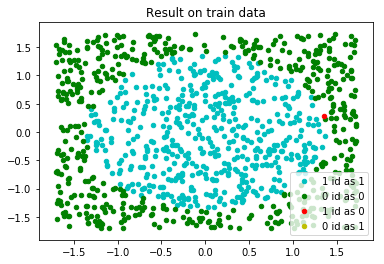

In [19]:
#Train set plot
id_class = output.argmax(dim=1)

one_id_as_one = torch.mul( (train_target[:,1]==1), (id_class ==1 ))
one_id_as_zero = torch.mul( (train_target[:,1]==1), (id_class ==0 ))
zero_id_as_one = torch.mul( (train_target[:,1]==0), (id_class ==1 ))
zero_id_as_zero = torch.mul( (train_target[:,1]==0), (id_class ==0 ))

plt.scatter(train_input[one_id_as_one,0] ,train_input[one_id_as_one,1], color = "c", s=20)
plt.scatter(train_input[zero_id_as_zero,0] ,train_input[zero_id_as_zero,1], color = "g", s=20)
plt.scatter(train_input[one_id_as_zero,0] ,train_input[one_id_as_zero,1], color = "r", s=20)
plt.scatter(train_input[zero_id_as_one,0] ,train_input[zero_id_as_one,1], color = "y", s=20)

plt.title("Result on train data")
plt.legend(["1 id as 1", "0 id as 0", "1 id as 0", "0 id as 1"] )
plt.show()

In [20]:
# Test set: 

output = model.forward(test_input)
l = model.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")

# print(output[0:10,:])
# print(test_target[0:10,:])


 
Loss:  0.026778321713209152
Number of errors:  10

 


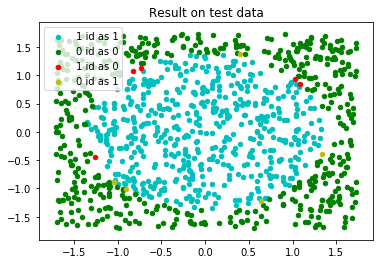

In [21]:
#Test set plot
id_class = output.argmax(dim=1)

one_id_as_one = torch.mul( (test_target[:,1]==1), (id_class ==1 ))
one_id_as_zero = torch.mul( (test_target[:,1]==1), (id_class ==0 ))
zero_id_as_one = torch.mul( (test_target[:,1]==0), (id_class ==1 ))
zero_id_as_zero = torch.mul( (test_target[:,1]==0), (id_class ==0 ))

plt.scatter(test_input[one_id_as_one,0] ,test_input[one_id_as_one,1], color = "c", s=20)
plt.scatter(test_input[zero_id_as_zero,0] ,test_input[zero_id_as_zero,1], color = "g", s=20)
plt.scatter(test_input[one_id_as_zero,0] ,test_input[one_id_as_zero,1], color = "r", s=20)
plt.scatter(test_input[zero_id_as_one,0] ,test_input[zero_id_as_one,1], color = "y", s=20)

plt.title("Result on test data")
plt.legend(["1 id as 1", "0 id as 0", "1 id as 0", "0 id as 1"] )
plt.show()

## Comparison Test

### Without autograd

In [22]:
# Model definition:
hidden_nb = 25

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model = Sequential([linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4 ], loss) 
    
std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000

model.normalize_parameters(mean=0, std=std)

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model.compute_loss(output, train_target.narrow(0, b, batch_size))
        model.backward()
        model.update_parameters(eta)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())
        eta = eta*0.95

0 :  0.6865123510360718
50 :  0.1357050985097885
100 :  0.10781310498714447
150 :  0.015072020702064037
200 :  0.013708495534956455
250 :  0.017927855253219604
300 :  0.021238403394818306
350 :  0.18168945610523224
400 :  0.022907713428139687
450 :  0.023377684876322746
500 :  0.021416015923023224
550 :  0.01810302771627903
600 :  0.015035400167107582
650 :  0.013522949069738388
700 :  0.012320556677877903
750 :  0.011464843526482582
800 :  0.010722655802965164
850 :  0.010015868581831455
900 :  0.00930175743997097
950 :  0.008596191182732582


### With autograd

In [53]:
import torch.nn as nn

from torch.autograd import Variable
from torch.nn import functional as F

torch.set_grad_enabled(True)
train_input = Variable(train_input.data, requires_grad=True)

class Net(nn.Module):
    def __init__(self, hidden_neurons = 25):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, hidden_neurons)
        self.fc2 = nn.Linear(hidden_neurons, hidden_neurons)
        self.fc3 = nn.Linear(hidden_neurons, hidden_neurons)
        self.fc4 = nn.Linear(hidden_neurons, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, 2)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

new_train_target = train_target.max(1)[1]

model, criterion = Net(), nn.CrossEntropyLoss()

std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000
        
for epochs in range(epochs_number):
    # set model to training mode
    model.train(True)
        
    for b in range(0, Sample_number, batch_size):
        output = model.forward(train_input.narrow(0, b, batch_size))
        loss_value = criterion(output, new_train_target.narrow(0, b, batch_size).long())
        
        model.zero_grad()
        loss_value.backward()

        for p in model.parameters():
            p.data.sub_(eta * p.grad.data)
        
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())

torch.set_grad_enabled(False)

0 :  0.6897410750389099
50 :  0.09178580343723297
100 :  0.03970758616924286
150 :  0.02322864718735218
200 :  0.15744347870349884
250 :  0.014292674139142036
300 :  0.012594737112522125
350 :  0.018498655408620834
400 :  0.009115921333432198
450 :  0.02999766916036606
500 :  0.013654682785272598
550 :  0.008979253470897675
600 :  0.014002960175275803
650 :  0.015162833966314793
700 :  0.006549541838467121
750 :  0.3699357509613037
800 :  0.009914927184581757
850 :  0.004245053976774216
900 :  0.006242357660084963
950 :  0.005089828744530678
